<a href="https://colab.research.google.com/github/AMITG4449/Large-language-model-/blob/main/LLM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing and importing necessary libraries**

In [1]:
# Install necessary libraries
!pip install transformers datasets evaluate scikit-learn

# Import required libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is 

In [2]:
# Step 1: Install Optuna
!pip install optuna

# Step 2: Import Optuna
import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


*   **Loading Dataset and Tokenizer**
*   **Applying Tokenizer to remove text column and rename the columns(setting format)**







In [3]:
dataset = load_dataset('yelp_polarity', split={'train': 'train[:5000]', 'test': 'test[:1000]'})

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Apply tokenization and remove text column
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# Rename the label column to 'labels' and set format to PyTorch tensors
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format('torch')

# Shuffle and create the final datasets
train_dataset = tokenized_datasets['train'].shuffle(seed=42)
test_dataset = tokenized_datasets['test'].shuffle(seed=42)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

**Loading BERT models,Defining training arguments and training the model.**

Calculating Accuracy, Precision, Recall and F1 Score.

In [4]:
# Define the compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.305300,0.197509,0.946000,0.945833,0.941909,0.943867
2,0.140700,0.201503,0.951000,0.944559,0.954357,0.949432


TrainOutput(global_step=1250, training_loss=0.20108686065673828, metrics={'train_runtime': 1027.932, 'train_samples_per_second': 9.728, 'train_steps_per_second': 1.216, 'total_flos': 2631110553600000.0, 'train_loss': 0.20108686065673828, 'epoch': 2.0})

**Display of results in tabular format.**

In [5]:
results = trainer.evaluate()
print(results)

# Convert the results to a DataFrame for better visualization
results_df = pd.DataFrame(list(results.items()), columns=['Metric', 'Value'])

# Display results in a table format
print(results_df)

{'eval_loss': 0.20150256156921387, 'eval_accuracy': 0.951, 'eval_precision': 0.944558521560575, 'eval_recall': 0.9543568464730291, 'eval_f1': 0.9494324045407636, 'eval_runtime': 28.9672, 'eval_samples_per_second': 34.522, 'eval_steps_per_second': 4.315, 'epoch': 2.0}
                    Metric      Value
0                eval_loss   0.201503
1            eval_accuracy   0.951000
2           eval_precision   0.944559
3              eval_recall   0.954357
4                  eval_f1   0.949432
5             eval_runtime  28.967200
6  eval_samples_per_second  34.522000
7    eval_steps_per_second   4.315000
8                    epoch   2.000000


**Display of results in graphical format.**

<ipython-input-6-147d4ddc56af>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Value', y='Metric', data=results_df, palette='viridis')


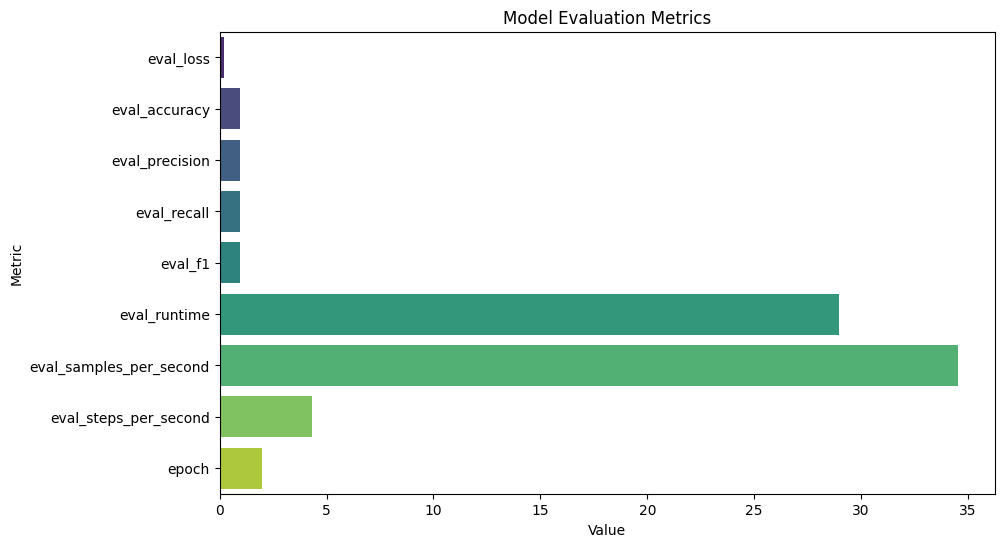

In [6]:
# Visualization of evaluation metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Value', y='Metric', data=results_df, palette='viridis')
plt.title('Model Evaluation Metrics')
plt.xlabel('Value')
plt.ylabel('Metric')
plt.show()

**Hypertuning of model fitting, testing, using epoch=2 and number of trails=10**

In [7]:
# Hyperparameter search using Optuna
def model_init():
    return BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

def objective(trial):
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
        per_device_train_batch_size=trial.suggest_categorical('per_device_train_batch_size', [8]),
        per_device_eval_batch_size=trial.suggest_categorical('per_device_eval_batch_size', [8]),
        num_train_epochs=2,
        weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
        logging_dir='./logs',
        report_to="none"
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result['eval_accuracy']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)
best_trial = study.best_trial

print(f'Best trial: {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

[I 2024-08-14 18:39:45,522] A new study created in memory with name: no-name-1f0d2552-dd79-409a-a73d-4f3ceb3fcffd
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassific

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.303600,0.209665,0.945000,0.936605,0.950207,0.943357
2,0.158100,0.210115,0.950000,0.948133,0.948133,0.948133


[I 2024-08-14 18:57:25,227] Trial 0 finished with value: 0.95 and parameters: {'learning_rate': 1.3088304251405736e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.027461026440996385}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.302200,0.211056,0.946000,0.947699,0.939834,0.943750
2,0.157500,0.211519,0.948000,0.951681,0.939834,0.945720


[I 2024-08-14 19:15:08,587] Trial 1 finished with value: 0.948 and parameters: {'learning_rate': 1.1808081014847625e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.011891782938676444}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depr

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.295400,0.213909,0.943000,0.932790,0.950207,0.941418
2,0.142800,0.198658,0.950000,0.948133,0.948133,0.948133


[I 2024-08-14 19:32:38,612] Trial 2 finished with value: 0.95 and parameters: {'learning_rate': 2.2291678355521638e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.014780451370372035}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.309100,0.217113,0.937000,0.919840,0.952282,0.935780
2,0.141700,0.227361,0.947000,0.935091,0.956432,0.945641


[I 2024-08-14 19:50:21,739] Trial 3 finished with value: 0.947 and parameters: {'learning_rate': 4.242148315656315e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.011641554051751895}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.294000,0.206665,0.948000,0.946058,0.946058,0.946058
2,0.149900,0.227595,0.947000,0.938650,0.952282,0.945417


[I 2024-08-14 20:07:54,005] Trial 4 finished with value: 0.947 and parameters: {'learning_rate': 2.424627896087757e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.06691786658178571}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprec

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.301300,0.202492,0.946000,0.945833,0.941909,0.943867
2,0.143700,0.212407,0.947000,0.945946,0.943983,0.944964


[I 2024-08-14 20:25:23,704] Trial 5 finished with value: 0.947 and parameters: {'learning_rate': 1.5074505337315192e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.024448876012563826}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depr

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.302700,0.227262,0.940000,0.939583,0.935685,0.937630
2,0.152400,0.212952,0.945000,0.943867,0.941909,0.942887


[I 2024-08-14 20:43:03,392] Trial 6 finished with value: 0.945 and parameters: {'learning_rate': 1.5108693943533736e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.05402346349359773}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depre

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.318600,0.177502,0.948000,0.946058,0.946058,0.946058
2,0.144400,0.241273,0.949000,0.933602,0.962656,0.947906


[I 2024-08-14 21:00:40,584] Trial 7 finished with value: 0.949 and parameters: {'learning_rate': 4.328076311254197e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.06024570173224795}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprec

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.305200,0.214479,0.946000,0.934959,0.954357,0.944559
2,0.162600,0.217512,0.947000,0.945946,0.943983,0.944964


[I 2024-08-14 21:18:07,544] Trial 8 finished with value: 0.947 and parameters: {'learning_rate': 1.0729866620886207e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.021230807391903046}. Best is trial 0 with value: 0.95.
<ipython-input-7-31a36aaa2df7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 5e-5),
<ipython-input-7-31a36aaa2df7>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform('weight_decay', 0.01, 0.1),
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is depr

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299000,0.203153,0.945000,0.933063,0.954357,0.943590
2,0.141600,0.213465,0.952000,0.939271,0.962656,0.950820


[I 2024-08-14 21:35:46,696] Trial 9 finished with value: 0.952 and parameters: {'learning_rate': 2.116023378724744e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.02040646900148502}. Best is trial 9 with value: 0.952.


Best trial: 0.952
Best hyperparameters: {'learning_rate': 2.116023378724744e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'weight_decay': 0.02040646900148502}


**Visualization of training metrics**

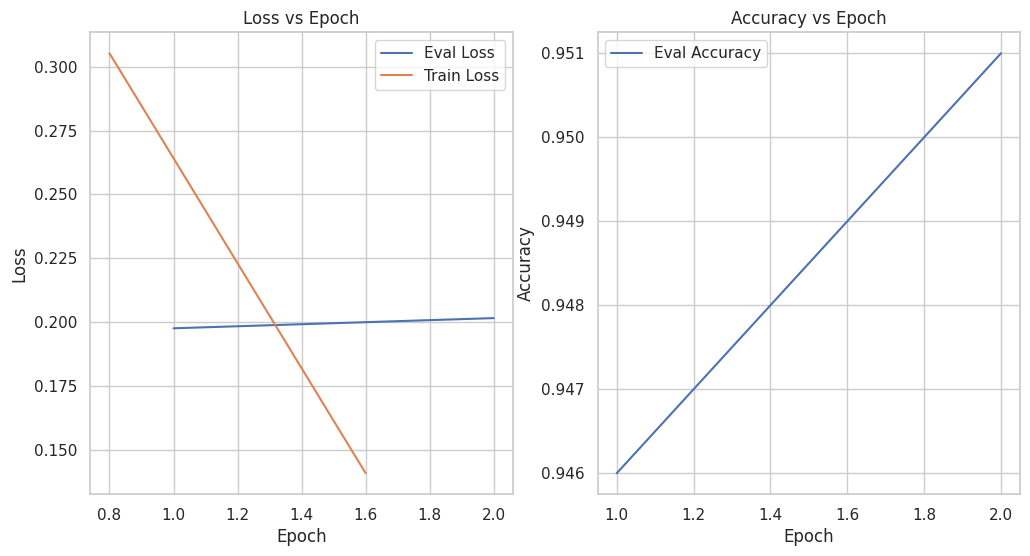

              precision    recall  f1-score   support

    Negative       0.96      0.95      0.95       518
    Positive       0.94      0.95      0.95       482

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [8]:
# Visualization of training metrics
df = pd.DataFrame(trainer.state.log_history)
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x='epoch', y='eval_loss', label='Eval Loss')
sns.lineplot(data=df, x='epoch', y='loss', label='Train Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(data=df, x='epoch', y='eval_accuracy', label='Eval Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Detailed classification report
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
